In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 




In [2]:
key = random.PRNGKey(0)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

x = random.normal(key, shape=(n,))*3
x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([x_diff, x2_or]))
theta = jnp.array([-3, 1.5])
gamma = jnp.array([1.1, 0.2, -1, 1])

triu_star_probs = expit(jnp.dot(df_edges, theta))
triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))


triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
Z = random.binomial(key, n=1, p=0.5, shape=(n,))
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))
eta = jnp.array([-1, 3, -0.25, 3])

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

Y = random.normal(key, shape=(n,))*sig_y + mean_y

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


mean exposure:  0.70646095 
 std exposure:  0.5411636 
 median exposure:  0.66232467


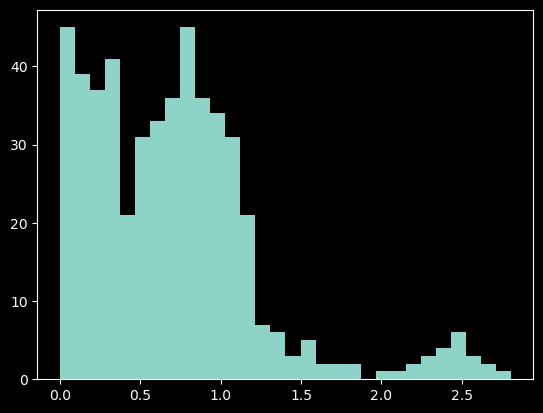

In [3]:
plt.hist(exposures, bins=30)
print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

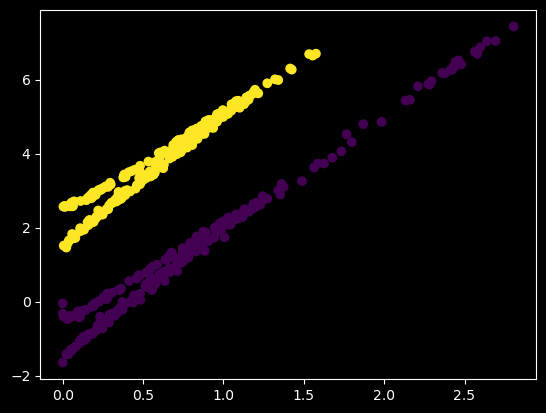

In [4]:
plt.scatter(exposures, Y, c=Z)

In [5]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:]))
    a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [6]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-53764.203, dtype=float32), Array([-0.40488562, -2.3433218 , -0.01463171, ..., -0.39524946,
       -0.1137819 , -3.2216356 ], dtype=float32))
(Array(-54012.17, dtype=float32), Array([-248.37363, -250.31206, -247.98337, ..., -248.36398, -248.08252,
       -251.19037], dtype=float32))


(124750,) (124750,)
-54012.17 
 [ -4.3274612 -13.518629  -18.89097     0.9562459  -8.715418  -12.617494
  -8.96564   -13.198547  -16.84104  ]


(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        6.000e+00, 2.000e+00, 5.000e+00, 9.000e+00, 7.000e+00, 5.000e+00,
        6.000e+00, 5.000e+00, 5.000e+00, 1.000e+01, 8.000e+00, 1.200e+01,
        1.700e+01, 7.000e+00, 1.900e+01, 1.500e+01, 2.100e+01, 2.700e+01,
        2.500e+01, 3.000e+01, 4.100e+01, 4.300e+01, 4.900e+01, 6.500e+01,
        8.500e+01, 9.200e+01, 1.080e+02, 1.230e+02, 1.350e+02, 1.610e+02,
        1.760e+02, 1.950e+02, 2.440e+02, 2.740e+02, 2.840e+02, 3.550e+02,
        3.690e+02, 4.010e+02, 4.860e+02, 5.290e+02, 5.740e+02, 6.430e+02,
        6.570e+02, 8.010e+02, 8.450e+02, 9.280e+02, 1.048e+03, 1.090e+03,
        1.184e+03, 1.283e+03, 1.329e+03, 1.421e+03, 1.533e+03, 1.685e+03,
        1.825e+03, 1.879e+03, 2.003e+03, 2.165e+03, 2.247e+03, 2.314e+03,
        2.490e+03, 2.551e+03, 2.668e+03, 2.853e+03, 2.976e+03, 3.151e+03,
        3.108e+03, 3.297e+03, 3.454e+0

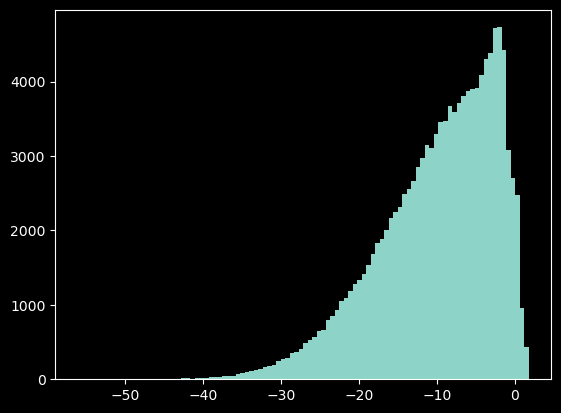

In [7]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

In [8]:
# create a function that `flip` triu_star value (0->1, 1->0), each at a time
#  and for each flip compute difference in log prob (sum)

@jax.jit
def edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx):
    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    _ ,log_prob = A_star_cond_log_post(new_triu_star[idx], triu_obs[idx], df_edges[idx,:], theta, gamma)
    return log_prob
    # return log_prob[idx]

# now wrap for all idx

@jax.jit
def flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set):
    return jnp.array([edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx) for idx in tqdm(idx_set)])

(124750,) (124750,)
flip check True
flip check 2 False
manual flip time 0.22102999687194824
(100,)


100%|██████████| 100/100 [00:00<00:00, 1946.06it/s]


func flip time 7.153838157653809
(100,)
True


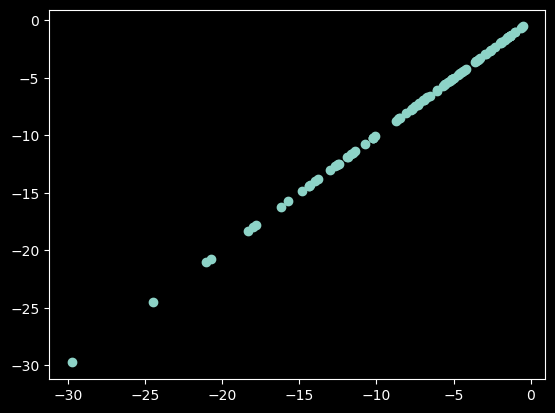

In [55]:
# samples idx_set as 100 values from triu_star

idx_set = random.choice(key, triu_dim, shape=(100,), replace=False)
# print(idx_set)

new_triu_star = triu_star.at[idx_set].set(1 - triu_star[idx_set])
print(triu_star.shape, new_triu_star.shape)

print("flip check", jnp.allclose(new_triu_star[idx_set], 1 - triu_star[idx_set]))
print("flip check 2", jnp.allclose(new_triu_star[idx_set],triu_star[idx_set]))


start = time.time()
_, manual_flip_loglik = A_star_cond_log_post(new_triu_star[idx_set], 
                                             triu_obs[idx_set],
                                               df_edges[idx_set,:],
                                                theta, gamma)
print("manual flip time", time.time() - start)

# manual_flip_loglik_min = manual_flip_loglik[idx_set]
print(manual_flip_loglik.shape)
# print(manual_flip_loglik_min.shape)

start = time.time()
func_flip_loglik = flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set)
print("func flip time", time.time() - start)

print(func_flip_loglik.shape)

print(jnp.allclose(manual_flip_loglik, func_flip_loglik))

plt.scatter(manual_flip_loglik, func_flip_loglik)

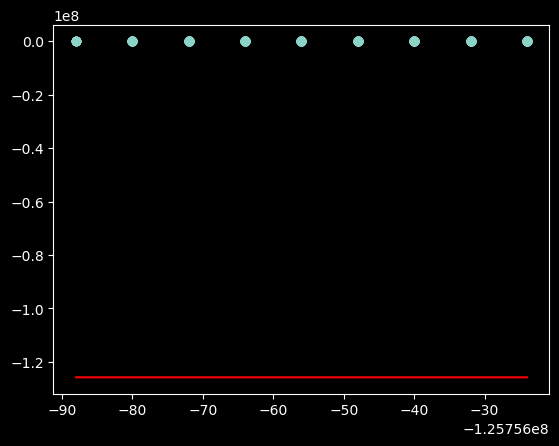

In [12]:
#  manual diff

# _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
# _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, theta, gamma)
_, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
_, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)

grad_manual = f_a_tag - f_a

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

# plt.hist(score_grad, bins=100)
plt.scatter(grad_manual, score_grad)
#  add y~x line
plt.plot([min(grad_manual), max(grad_manual)], [min(grad_manual), max(grad_manual)], color='red')
# plt.hist(grad_manual - score_grad, bins=100)

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 4.000e+00,
        6.000e+00, 1.100e+01, 5.000e+00, 6.000e+00, 6.000e+00, 8.000e+00,
        1.000e+01, 9.000e+00, 1.400e+01, 1.600e+01, 1.900e+01, 1.900e+01,
        1.900e+01, 3.000e+01, 3.800e+01, 3.000e+01, 4.300e+01, 6.000e+01,
        7.300e+01, 9.300e+01, 1.050e+02, 1.320e+02, 1.510e+02, 1.760e+02,
        1.940e+02, 2.110e+02, 2.890e+02, 3.070e+02, 3.720e+02, 4.180e+02,
        4.280e+02, 5.620e+02, 6.050e+02, 6.670e+02, 7.330e+02, 8.550e+02,
        9.430e+02, 1.047e+03, 1.181e+03, 1.265e+03, 1.417e+03, 1.503e+03,
        1.607e+03, 1.701e+03, 1.910e+03, 2.093e+03, 2.191e+03, 2.400e+03,
        2.529e+03, 2.621e+03, 2.842e+03, 2.929e+03, 3.150e+03, 3.307e+03,
        3.496e+03, 3.613e+03, 3.740e+03, 3.954e+03, 4.036e+03, 4.205e+03,
        4.185e+03, 4.301e+03, 4.457e+03, 4.365e+03, 4.456e+03, 4.557e+03,
        4.668e+03, 4.651e+03, 4.696e+0

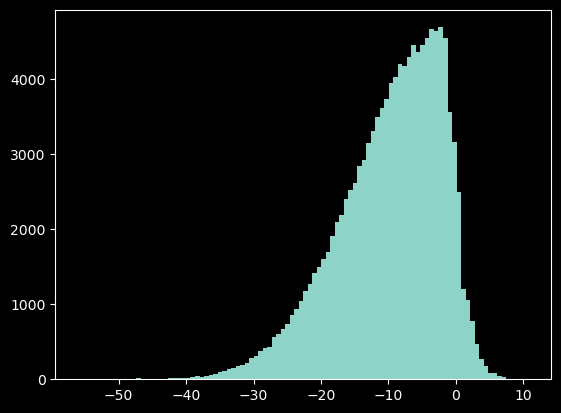

In [13]:
plt.hist(score_grad, bins=100)

In [16]:
# compare jax grad with manual grad running time by changing theta[0] values 


start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "jax grad"):
    c_theta = jnp.array([theta_0, 1.5])
    # (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma)
    (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)

print("jax time: ", time.time() - start)

start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "manual grad"):
    c_theta = np.array([theta_0, 1.5])
    _, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    _, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    # _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, c_theta, gamma)
    # _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, c_theta, gamma)
    grad_manual = f_a_tag - f_a

print("manual time: ", time.time() - start)



jax grad: 100%|██████████| 2000/2000 [00:21<00:00, 94.33it/s] 


jax time:  21.23240041732788


manual grad: 100%|██████████| 2000/2000 [00:18<00:00, 109.44it/s]

manual time:  18.275511741638184


In [10]:
print(grad_manual.shape, gradient.shape)

(124750,) (124750,)


min:  6.7267925e-13 max:  0.99546766 
 mean:  0.105714016 median:  0.013557847 
 q025:  9.975478e-07 q975:  0.6637729
min:  9.103724e-14 max:  0.96745276 
 mean:  0.025980191 median:  0.0018566202 
 q025:  1.3500353e-07 q975:  0.21084379


(array([5.8626e+04, 8.6670e+03, 5.2760e+03, 3.8300e+03, 3.1470e+03,
        2.5160e+03, 2.1760e+03, 1.9210e+03, 1.7070e+03, 1.5670e+03,
        1.5030e+03, 1.2810e+03, 1.2750e+03, 1.2530e+03, 1.1170e+03,
        1.0080e+03, 1.0490e+03, 9.6200e+02, 9.4900e+02, 8.2800e+02,
        8.7300e+02, 8.5100e+02, 8.1700e+02, 7.9000e+02, 7.4100e+02,
        7.3200e+02, 7.1000e+02, 6.6800e+02, 6.8700e+02, 6.0700e+02,
        5.8100e+02, 6.6800e+02, 6.3000e+02, 6.4400e+02, 6.1700e+02,
        5.9300e+02, 5.3100e+02, 5.1000e+02, 4.5900e+02, 3.9600e+02,
        4.0500e+02, 3.6000e+02, 3.5100e+02, 3.2100e+02, 3.4300e+02,
        3.5400e+02, 3.6300e+02, 3.7600e+02, 4.0800e+02, 4.0100e+02,
        4.5900e+02, 4.3600e+02, 4.1400e+02, 3.7100e+02, 3.6000e+02,
        2.8700e+02, 2.3700e+02, 2.1900e+02, 1.8600e+02, 1.8900e+02,
        1.8400e+02, 1.4400e+02, 1.5500e+02, 1.4100e+02, 1.4300e+02,
        1.5700e+02, 1.6900e+02, 1.4800e+02, 1.5800e+02, 1.5100e+02,
        1.5400e+02, 1.6000e+02, 1.5700e+02, 1.33

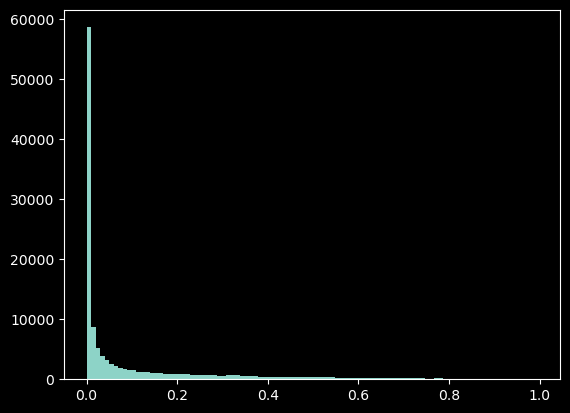

In [57]:
# grad_on_idx = (f_a_tag - f_a)/2
grad_on_idx = score_grad / 2

flip_probs = jnp.exp(grad_on_idx) / (jnp.exp(grad_on_idx) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs), "max: ", jnp.max(flip_probs), "\n",
      "mean: ", jnp.mean(flip_probs),
      "median: ", jnp.median(flip_probs), "\n",
      "q025: ", jnp.quantile(flip_probs, 0.025),
        "q975: ", jnp.quantile(flip_probs, 0.975))

flip_probs_rate = jnp.exp(grad_on_idx - 2) / (jnp.exp(grad_on_idx - 2) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs_rate), "max: ", jnp.max(flip_probs_rate), "\n",
      "mean: ", jnp.mean(flip_probs_rate),
      "median: ", jnp.median(flip_probs_rate), "\n",
      "q025: ", jnp.quantile(flip_probs_rate, 0.025),
        "q975: ", jnp.quantile(flip_probs_rate, 0.975))

plt.hist(flip_probs, bins=100)

In [110]:
# sample uniform[0,1] with dim as flip_probs_rate
# and compare with flip_probs_rate
flip_edges = random.uniform(key, shape=(triu_dim,)) < flip_probs_rate
print(flip_edges.mean(), flip_edges.sum())


0.025258515 3151


0.2677551 267.75507
0.09841587
9.357623e-14


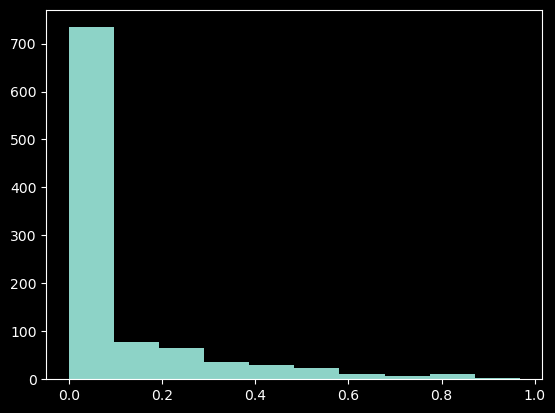

In [55]:
idxs = random.choice(key, triu_dim, shape=(1000,), replace=False)
prop_triu = triu_star.at[idxs].set(1 - triu_star[idxs])

_, tst_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
tst_grad = tst_grad[idxs]

temp_ratio = jnp.exp((-(2*triu_star[idxs]-1)*tst_grad)/2. - 0)
print(temp_ratio.mean(), temp_ratio.sum())
temp_ratio = jnp.clip(temp_ratio, -30, 30)
temp_prob = temp_ratio / (temp_ratio + 1)
print(temp_prob.mean())

plt.hist(temp_prob)

print(jnp.exp(-30) / (jnp.exp(-30) + 1))

In [9]:
# g_grad = jnp.exp(score_grad) / (jnp.exp(score_grad) + 1)
# g_grad = score_grad / 2

# print(g_grad.min(), g_grad.max())
# tst_samp = random.categorical(key, logits=g_grad, shape=(1,))
# print(tst_samp, g_grad[tst_samp])

def weighted_sample_and_logprobs(key, scores, M):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    selected_indices = jnp.argsort(-perturbed)[:M]

     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()



# w_samp, w_logprob = weighted_sample_and_logprobs(key, g_grad, 3)
# print(w_samp, g_grad[w_samp])
# print(w_logprob)


In [69]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .001
# BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
BATCH_LEN = 5
# print(BATCH_LEN)

@jax.jit
def triu_star_update(triu_star, cur_scores, cur_logpost, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, key, alpha = jnp.log(2), eps = 1e-10):
    
    key1, key2, key3 = random.split(key, 3)
    # sample mini-batch for potential edge flip
    # idx_set = random.choice(key1, TRIU_LEN, 
    #                         shape=(BATCH_LEN,),
    #                           replace=False)
 
    # Approximate with gradient
    # (f_baseline,_), baseline_edge_loglik = val_grad_fn(triu_star, triu_obs, df_edges,
    #                                         theta, gamma, Y, x, Z, eta)
    # (cur_logpost,_), cur_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            # theta, gamma, Y, x, Z, eta)
    # # get forward proposals q(i|A*_t)
    # # baseline_scores = -(2*triu_star-1)*baseline_edge_loglik/2 - alpha 
    # baseline_scores = (-(2*triu_star-1)*baseline_edge_loglik)/2
    # cur_scores = (-(2*triu_star-1)*cur_grad)/2
    # # baseline_scores = jnp.exp(baseline_scores) / (jnp.exp(baseline_scores) + 1)
    # # baseline_scores = jnp.clip(baseline_scores, -30, 30)

    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores*jnp.exp(-alpha), BATCH_LEN)
    idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)

    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])

    # backward proposal
    (f_proposed,_), backward_edge_loglik = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, x, Z, eta)
    # backward_scores = -(2*new_triu_star-1)*backward_edge_loglik/2 - alpha
    backward_scores = (-(2*new_triu_star-1)*backward_edge_loglik)/2
    # backward_scores = jnp.exp(backward_scores) / (jnp.exp(backward_scores) + 1)
    # backward_scores = jnp.clip(backward_scores, -30, 30)
    backward_logprob = propsal_logprobs(idx, backward_scores*jnp.exp(-alpha))



    # baseline_edge_loglik = baseline_edge_loglik[idx_set]
    # compute g(exp(d(\tilde{A}*_t, A*_t))) for g(a) = \sqrt{a} 
    # temp_lik_ratio = jnp.exp((-(2*triu_star[idx_set]-1)*baseline_edge_loglik)/2. - alpha)
    # temp_lik_ratio = jnp.exp((-(2*triu_star-1)*baseline_edge_loglik)/2. - alpha)
    # temp_lik_ratio = jnp.clip(temp_lik_ratio, -30, 30)

    # compute proposal probabilities q(\tilde{A}*_t|A*_t) \propto Softmax(exp(d(\tilde{A}*_t, A*_t)/2))
    # forward_flip_probs = temp_lik_ratio / (temp_lik_ratio + 1)

    # sample flip indicator I
    # flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < forward_flip_probs
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    # forward_probs = forward_flip_probs * flip_indicator + (1 - forward_flip_probs) * (1 - flip_indicator)
    # forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    # new_triu_star = triu_star.at[idx_set].set(flip_indicator * (1 - triu_star[idx_set]) +
                                            #   (1 - flip_indicator) * triu_star[idx_set])

    
    # Backward proposal
    # _, new_edge_loglik = A_star_cond_log_post(new_triu_star[idx_set],
    #                                           triu_obs[idx_set],
    #                                           df_edges[idx_set,:],
    #                                           theta, gamma) 
    # (_,_), new_edge_loglik = val_grad_fn(new_triu_star, triu_obs, df_edges,
    #                                         theta, gamma, Y, x, Z, eta)
    # new_edge_loglik = new_edge_loglik[idx_set]
    # # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - proposed_edge_loglik)/2.)
    # # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - new_edge_loglik)/2. - alpha)
    # backward_temp_lik_ratio = jnp.exp((-(2*triu_star[idx_set]-1)*new_edge_loglik)/2. - alpha)
    # backward_temp_lik_ratio = jnp.clip(backward_temp_lik_ratio, -30, 30)

    # # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - proposed_edge_loglik)/2. - alpha)
    # backward_flip_probs = backward_temp_lik_ratio / (backward_temp_lik_ratio + 1)
    # backward_probs = backward_flip_probs * flip_indicator + (1 - backward_flip_probs) * (1 - flip_indicator)
    # backward_proposal = jnp.sum(jnp.log(backward_probs + eps))

    # compute full (f) log-posterior diff $f(A*_new) - f(A*_baseline)$
    # f_baseline, _ = A_star_cond_log_post(triu_star, triu_obs, df_edges,
    #                                              theta, gamma)
    # f_proposed, _ = A_star_cond_log_post(new_triu_star, triu_obs, df_edges,
    #                                               theta, gamma)
    # f_baseline, _ = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges,
    #                                              theta, gamma,
    #                                              Y, X, Z, eta)
    # f_proposed, _ = A_star_cond_log_post_with_Y(new_triu_star, triu_obs, df_edges,
    #                                               theta, gamma,
    #                                               Y, X, Z, eta)
    
#     print("forward proposal: ", forward_proposal, "\n",
#            "backward proposal: ", backward_proposal)
    # compute acceptance ratio
    # acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_proposal - forward_proposal),
    #                             a_max=1)
    # acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_logprob - forward_logprob),
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - cur_logpost + backward_logprob - forward_logprob),
                                a_max=1)
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # if i % 100 == 0:
    #     print("prop flipped from possible: ", flip_indicator.mean(), "; total:" , flip_indicator.sum())
    #     print("Update triu_star: ", accept, "; Acceptance prob:", acceptance_ratio)
    #     print("full posterior diff: ", f_proposed - f_baseline)
    #     print("reverse proposal diff", backward_proposal - forward_proposal)
#     print("Update triu_star: ", accept, "; Acceptance prob:", acceptance_ratio)
    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    cur_scores = jax.lax.select(accept, backward_scores, cur_scores)
    cur_logpost = jax.lax.select(accept, f_proposed, cur_logpost)
    # return new_triu_star, acceptance_ratio
    return new_triu_star, acceptance_ratio, cur_scores, cur_logpost
    
     

In [35]:
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, gamma=0.05):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    adjustment = gamma * (target_rate - acceptance_rate)
    return alpha + adjustment

In [70]:
# make noisy triu_star

triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.2, shape=(triu_dim,)))

eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)
# theta_n[1] = theta_n[1] - 1.5
# test A_star update
# triu_len = triu_star_noisy.shape[0]
# batch_prop = 0.5
# batch_len = int(triu_len * batch_prop)
# new_triu_star = triu_star_update(triu_star_noisy, triu_obs, df_edges,
#                                   theta, gamma, Y, x, Z, eta, key,
#          
#                           triu_len, batch_len)
# alpha = jnp.log(2.0)
alpha = 1.001
n_iter = 5000
new_triu_star = triu_star_noisy
exposures_lst = [compute_exposures(new_triu_star, Z)]
log_post = []
acceptance_rates = []
# acceptance_rates = jnp.zeros
ADAPT_WINDOW = 100

(cur_logpost,_), cur_grad = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                            theta_n, gamma, Y, x, Z, eta_n)

log_post.append(cur_logpost)
    # get forward proposals q(i|A*_t)
    # baseline_scores = -(2*triu_star-1)*baseline_edge_loglik/2 - alpha 
cur_scores = (-(2*new_triu_star-1)*cur_grad)/2
    # baseline_scores = jnp.exp(baseline_scores) / (jnp.exp(baseline_scores) + 1)
    # baseline_scores = jnp.clip(baseline_scores, -30, 30)

    # (f_baseline,_), baseline_edge_loglik = val_grad_fn(triu_star, triu_obs, df_edges,
    #                                         theta, gamma, Y, x, Z, eta)
    # # get forward proposals q(i|A*_t)
    # # baseline_scores = -(2*triu_star-1)*baseline_edge_loglik/2 - alpha 
    # baseline_scores = (-(2*triu_star-1)*baseline_edge_loglik)/2

start = time.time()
for i in tqdm(range(int(n_iter))):
    key, _ = random.split(key)
    # new_triu_star, acc = triu_star_update(new_triu_star,
    #                                         triu_obs, df_edges,
    #                                   theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
    new_triu_star, acc, cur_scores, cur_logpost = triu_star_update(new_triu_star,
                                                                   cur_scores, cur_logpost,
                                                                    triu_obs, df_edges,
                                      theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
    exposures_lst.append(compute_exposures(new_triu_star, Z))
    acceptance_rates.append(acc)
    log_post.append(cur_logpost)
    # if i % 500 == 0:
    #     print("key: ", key)
    #     # print("idx_set: ", idx_set)
    #     print("Acceptance rate: ", acc)
    #     # print("prop flipped from possible: ", ind)
    #     print("full posterior diff: ", f_diff)
    #     print("reverse proposal diff", q_diff)
    #     print("base scores: ", base_sc)
    #     print("back scores: ", back_sc)
    #     # print("temp lik ratio mean: ", b)
    if i % ADAPT_WINDOW == 0:
        # mean_acceptance_rate = jnp.mean(jnp.array(acceptance_rates[-ADAPT_WINDOW:]))
        mean_acceptance_rate = np.mean(acceptance_rates[-ADAPT_WINDOW:])
        alpha = adaptive_step_size(alpha, mean_acceptance_rate)
        print(f"Iteration {i}, New Alpha: {alpha}, Acceptance Rate: {mean_acceptance_rate}")

        # eta_n[-1] = eta_n[-1] + 0.04
        eta_n = eta_n.at[3].set(eta_n[3] + 0.02)
        # theta_n[1] = theta_n[1] + 0.03
        theta_n = theta_n.at[1].set(theta_n[1] + 0.015)

print("for loop total time: ", time.time() - start)

    


Iteration 0, New Alpha: 0.9796999999999999, Acceptance Rate: 1.0


Iteration 100, New Alpha: 1.0084, Acceptance Rate: 0.0


Iteration 200, New Alpha: 1.0371, Acceptance Rate: 0.0


Iteration 300, New Alpha: 1.0657999999999999, Acceptance Rate: 0.0


Iteration 400, New Alpha: 1.0944999999999998, Acceptance Rate: 0.0


Iteration 500, New Alpha: 1.1231999999999998, Acceptance Rate: 0.0


Iteration 600, New Alpha: 1.1518999999999997, Acceptance Rate: 0.0


Iteration 700, New Alpha: 1.1805999999999996, Acceptance Rate: 0.0


Iteration 800, New Alpha: 1.2092999999999996, Acceptance Rate: 0.0


Iteration 900, New Alpha: 1.2379999999999995, Acceptance Rate: 0.0


Iteration 1000, New Alpha: 1.2666999999999995, Acceptance Rate: 0.0


 22%|██▏       | 1090/5000 [01:10<04:14, 15.36it/s]


KeyboardInterrupt: 

In [ ]:


n_iter = 10000

# Main loop body for `jax.fori_loop`
def loop_body(i, state):
    new_triu_star, exposures_lst, acceptance_rates, alpha, eta_n, theta_n, key = state

    # Update key
    key, subkey = random.split(key)

    # Perform update step
    new_triu_star, f_diff, q_diff, acc, base_sc, back_sc = triu_star_update(
        new_triu_star, triu_obs, df_edges, theta_n, gamma, Y, x, Z, eta_n, subkey, alpha=alpha
    )

    # Compute exposures and update acceptance rates
    exposures_lst = exposures_lst.at[i].set(compute_exposures(new_triu_star, Z).mean())
    acceptance_rates = acceptance_rates.at[i].set(acc)

    # Adapt step size every `ADAPT_WINDOW` iterations
    adapt_condition = (i % ADAPT_WINDOW == 0) & (i > 0)
    idx = jnp.arange(n_iter)
    window_mask = (idx >= jnp.maximum(0, i - ADAPT_WINDOW)) & (idx < i)
    mean_acceptance_rate = jnp.sum(acceptance_rates * window_mask) / jnp.maximum(1, jnp.sum(window_mask))

    # mean_acceptance_rate = jnp.mean(acceptance_rates[i - ADAPT_WINDOW : i])

    alpha = jax.lax.cond(
        adapt_condition,
        lambda _: adaptive_step_size(alpha, mean_acceptance_rate),
        lambda _: alpha,
        None,
    )

    # Update `eta_n` and `theta_n` every `ADAPT_WINDOW` iterations
    eta_n = jax.lax.cond(
        adapt_condition,
        lambda _: eta_n.at[3].set(eta_n[3] + 0.02),
        lambda _: eta_n,
        None,
    )
    theta_n = jax.lax.cond(
        adapt_condition,
        lambda _: theta_n.at[1].set(theta_n[1] + 0.015),
        lambda _: theta_n,
        None,
    )

    return new_triu_star, exposures_lst, acceptance_rates, alpha, eta_n, theta_n, key


# Initialize variables



eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)


exposures_lst = jnp.zeros(n_iter)
acceptance_rates = jnp.zeros(n_iter)
alpha = 1.0
ADAPT_WINDOW = 100

state = (
    triu_star_noisy,  # new_triu_star
    exposures_lst,    # exposures_lst
    acceptance_rates, # acceptance_rates
    alpha,            # alpha
    eta_n,            # eta_n
    theta_n,          # theta_n
    key               # key
)

# chunk_size = 100  # adjust based on your needs


# # Define your main computation in chunks
# n_chunks = n_iter // chunk_size
# state = (triu_star_noisy, exposures_lst, acceptance_rates, alpha, eta_n, theta_n, key)

# # Run in chunks with progress bar
# for chunk in tqdm(range(n_chunks), desc="MCMC Progress"):
#     start_idx = chunk * chunk_size
#     state = scan_tqdm(jax.lax.fori_loop, start_idx, start_idx + chunk_size, loop_body, state)

# # Handle remaining iterations
# remaining = n_iter % chunk_size
# if remaining > 0:
#     start_idx = n_chunks * chunk_size
#     state = scan_tqdm(jax.lax.fori_loop, start_idx, n_iter, loop_body, state)

start = time.time()
# Run `jax.fori_loop`
final_state = jax.lax.fori_loop(0, n_iter, loop_body, state)

# Extract final results
# new_triu_star, exposures_lst, acceptance_rates, alpha, eta_n, theta_n, key = final_state
new_triu_star, exposures_lst, acceptance_rates, alpha, eta_n, theta_n, key = state

print("fori_loop total time: ", time.time() - start)
# 

fori_loop total time:  646.5567696094513


In [ ]:
# TODO: see tradeoff between number BATCH_LEN and acceptance rate
# TODO: check why i have convergence issues
# TODO: see why jax.fori_loop didn't worked
# TODO: add code for continuous variables, e.g., using BlackJAX MCMC kernels

In [30]:
theta_n

Array([-3.,  0.], dtype=float32)

(10001, 500)
0.70646095
0.7690301


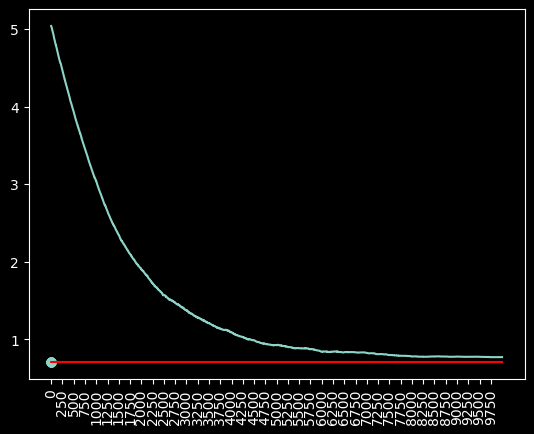

In [63]:
from sympy import rotations


expos_arr = jnp.array(exposures_lst)
print(expos_arr.shape)
print(exposures.mean())
plt.scatter(expos_arr.mean(axis=1), jnp.ones(expos_arr.shape[0])*exposures.mean())
print(expos_arr.mean(axis=1)[-1])

# plt.plot(expos_arr)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
plt.plot(expos_arr.mean(axis=1))
plt.plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
# add x-ticks vertical with 500 step siz
plt.xticks(range(0, n_iter, 250), rotation=90) 
plt.show()

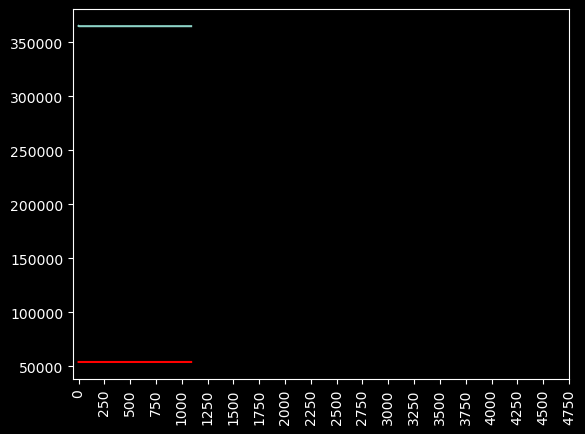

In [75]:
(true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)

plt.plot(-jnp.array(log_post))
plt.plot(-jnp.ones(len(log_post))*true_logpost, color="red")
plt.xticks(range(0, n_iter, 250), rotation=90)
plt.show()

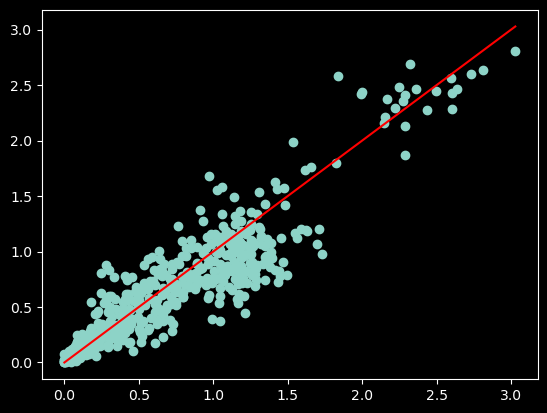

In [64]:
plt.scatter(expos_arr[-1,:], exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

In [65]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, triu_star_noisy))

print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == triu_star_noisy))

# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 114341 | 3819 |
   1    | 3828 | 2762 |
[[114341   3819]
 [  3828   2762]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 106434 | 11726 |
   1    | 652 | 5938 |
[[106434  11726]
 [   652   5938]]
0.93870133
0.9007775
